# Detecting Anomalies Using Heterogeneous GNNs

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData
from torch.nn import functional as F
from torch.optim import Adam
from torch import nn
import torch

In [2]:
df = pd.read_csv('CSV-original/traffic/OpenStack/CIDDS-001-internal-week1.csv')
df

/var/folders/bb/1pgmng2s0xl2b26dxfj33phm0000gn/T/ipykernel_84329/3004991613.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('CSV-original/traffic/OpenStack/CIDDS-001-internal-week1.csv')


,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,445,192.168.220.16,58844.0,1,108,1,.AP...,0,normal,---,---,---
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,48888,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,58844,192.168.100.5,445.0,2,174,1,.AP...,0,normal,---,---,---
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888.0,1,108,1,.AP...,0,normal,---,---,---
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8451515,2017-03-21 23:59:56.083,0.248,TCP,192.168.200.8,62605,EXT_SERVER,8082.0,2,319,1,.AP...,0,normal,---,---,---
8451516,2017-03-21 23:59:57.037,0.000,TCP,10179_174,443,192.168.210.5,51433.0,1,54,1,.A....,32,normal,---,---,---
8451517,2017-03-21 23:59:56.920,0.000,TCP,192.168.210.5,51433,10179_174,443.0,1,55,1,.A....,0,normal,---,---,---
8451518,2017-03-21 23:59:58.299,0.000,TCP,192.168.100.5,445,192.168.220.6,56281.0,1,108,1,.AP...,0,normal,---,---,---


In [3]:
df = df.drop(columns=['Src Pt', 'Dst Pt', 'Flows', 'Tos', 'class', 'attackID', 'attackDescription'])
#Labelling the empty ones as benign
df['attackType'] = df['attackType'].replace('---', 'benign')
#Converting to datetime format
df['Date first seen'] = pd.to_datetime(df['Date first seen'])
df.head()

,Date first seen,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,Flags,attackType
0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,192.168.220.16,1,108,.AP...,benign
1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign
2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,192.168.100.5,2,174,.AP...,benign
3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,192.168.100.5,2,174,.AP...,benign
4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,192.168.220.15,1,108,.AP...,benign


attackType
benign        82.954273
dos           14.815406
portScan       2.171337
pingScan       0.039744
bruteForce     0.019239
Name: count, dtype: float64


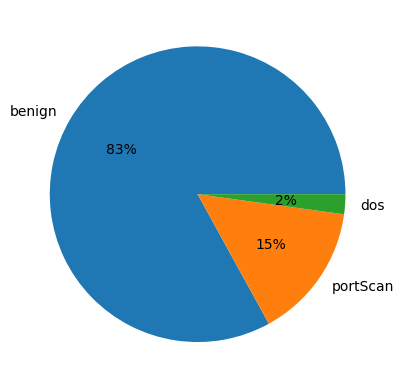

In [4]:
count_labels = df['attackType'].value_counts() / len(df) * 100
print(count_labels)
plt.pie(count_labels[:3], labels=df['attackType'].unique()[:3], autopct='%.0f%%')
plt.show()

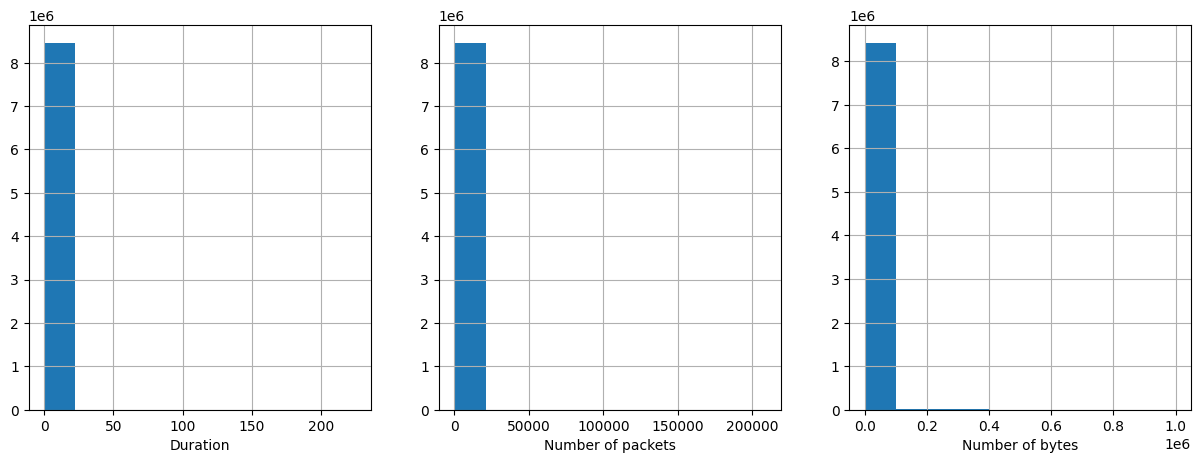

In [5]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,5))
df['Duration'].hist(ax=ax1)
ax1.set_xlabel("Duration")
df['Packets'].hist(ax=ax2)
ax2.set_xlabel("Number of packets")
pd.to_numeric(df['Bytes'], errors='coerce').hist(ax=ax3)
ax3.set_xlabel("Number of bytes")
plt.show()

Preprocessing the dataset

In [6]:
df['weekday'] = df['Date first seen'].dt.weekday
df = pd.get_dummies(df, columns=['weekday']).rename(columns = {'weekday_0': 'Monday',
                                                              'weekday_1': 'Tuesday',
                                                              'weekday_2': 'Wednesday',
                                                              'weekday_3': 'Thursday',
                                                              'weekday_4': 'Friday',
                                                              'weekday_5': 'Saturday',
                                                              'weekday_6': 'Sunday',
                                                             })

df['daytime'] = (df['Date first seen'].dt.second +df['Date first seen'].dt.minute*60 + df['Date first seen'].dt.hour*60*60)/(24*60*60)

In [7]:
def one_hot_flags(input):
    return [1 if char1 == char2 else 0 for char1, char2 in zip('APRSF', input[1:])]

df = df.reset_index(drop=True)
ohe_flags = one_hot_flags(df['Flags'].to_numpy())
ohe_flags = df['Flags'].apply(one_hot_flags).to_list()
df[['ACK', 'PSH', 'RST', 'SYN', 'FIN']] = pd.DataFrame(ohe_flags, columns=['ACK', 'PSH', 'RST', 'SYN', 'FIN'])
df = df.drop(columns=['Date first seen', 'Flags'])
df

,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN
0,0.000,TCP,192.168.100.5,192.168.220.16,1,108,benign,False,False,True,False,False,False,False,0.000880,1,1,0,0,0
1,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,False,False,True,False,False,False,False,0.000880,1,1,0,0,0
2,0.004,TCP,192.168.220.15,192.168.100.5,2,174,benign,False,False,True,False,False,False,False,0.000880,1,1,0,0,0
3,0.004,TCP,192.168.220.16,192.168.100.5,2,174,benign,False,False,True,False,False,False,False,0.000880,1,1,0,0,0
4,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,False,False,True,False,False,False,False,0.000880,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8451515,0.248,TCP,192.168.200.8,EXT_SERVER,2,319,benign,False,True,False,False,False,False,False,0.999954,1,1,0,0,0
8451516,0.000,TCP,10179_174,192.168.210.5,1,54,benign,False,True,False,False,False,False,False,0.999965,1,0,0,0,0
8451517,0.000,TCP,192.168.210.5,10179_174,1,55,benign,False,True,False,False,False,False,False,0.999954,1,0,0,0,0
8451518,0.000,TCP,192.168.100.5,192.168.220.6,1,108,benign,False,True,False,False,False,False,False,0.999977,1,1,0,0,0


In [8]:
#Changing IP addresses to a 16 bit representation
temp = pd.DataFrame()
temp['SrcIP'] = df['Src IP Addr'].astype(str)
temp['SrcIP'][~temp['SrcIP'].str.contains('\d{1,3}\.', regex=True)] = '0.0.0.0'
temp = temp['SrcIP'].str.split('.', expand=True).rename(columns = {2: 'ipsrc3', 3: 'ipsrc4'}).astype(int)[['ipsrc3', 'ipsrc4']]
temp['ipsrc'] = temp['ipsrc3'].apply(lambda x: format(x, "b").zfill(8)) + temp['ipsrc4'].apply(lambda x: format(x, "b").zfill(8))
df = df.join(temp['ipsrc'].str.split('', expand=True)
            .drop(columns=[0, 17])
            .rename(columns=dict(enumerate([f'ipsrc_{i}' for i in range(17)])))
            .astype('int32'))
df.head(5)

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/var/folders/bb/1pgmng2s0xl2b26dxfj33phm0000gn/T/ipykernel_84329/1165669167.py:4: SyntaxWarning: invalid escape sequence '\d'
  temp['SrcIP'][~temp['SrcIP'].str.contains('\d{1,3}\.', regex=True)] = '0.0.0.0'


,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN,ipsrc_1,ipsrc_2,ipsrc_3,ipsrc_4,ipsrc_5,ipsrc_6,ipsrc_7,ipsrc_8,ipsrc_9,ipsrc_10,ipsrc_11,ipsrc_12,ipsrc_13,ipsrc_14,ipsrc_15,ipsrc_16
0,0.000,TCP,192.168.100.5,192.168.220.16,1,108,benign,False,False,True,False,False,False,False,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
1,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,False,False,True,False,False,False,False,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
2,0.004,TCP,192.168.220.15,192.168.100.5,2,174,benign,False,False,True,False,False,False,False,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1
3,0.004,TCP,192.168.220.16,192.168.100.5,2,174,benign,False,False,True,False,False,False,False,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0
4,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,False,False,True,False,False,False,False,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1


In [9]:
temp = pd.DataFrame()
temp['DstIP'] = df['Dst IP Addr'].astype(str)
temp['DstIP'][~temp['DstIP'].str.contains('\d{1,3}\.', regex=True)] = '0.0.0.0'
temp = temp['DstIP'].str.split('.', expand=True).rename(columns = {2: 'ipdst3', 3: 'ipdst4'}).astype(int)[['ipdst3', 'ipdst4']]
temp['ipdst'] = temp['ipdst3'].apply(lambda x: format(x, "b").zfill(8)) \
                + temp['ipdst4'].apply(lambda x: format(x, "b").zfill(8))
df = df.join(temp['ipdst'].str.split('', expand=True)
            .drop(columns=[0, 17])
            .rename(columns=dict(enumerate([f'ipdst_{i}' for i in range(17)])))
            .astype('int32'))
df.head(5)

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/var/folders/bb/1pgmng2s0xl2b26dxfj33phm0000gn/T/ipykernel_84329/2640945434.py:3: SyntaxWarning: invalid escape sequence '\d'
  temp['DstIP'][~temp['DstIP'].str.contains('\d{1,3}\.', regex=True)] = '0.0.0.0'


,Duration,Proto,Src IP Addr,Dst IP Addr,Packets,Bytes,attackType,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN,ipsrc_1,ipsrc_2,ipsrc_3,ipsrc_4,ipsrc_5,ipsrc_6,ipsrc_7,ipsrc_8,ipsrc_9,ipsrc_10,ipsrc_11,ipsrc_12,ipsrc_13,ipsrc_14,ipsrc_15,ipsrc_16,ipdst_1,ipdst_2,ipdst_3,ipdst_4,ipdst_5,ipdst_6,ipdst_7,ipdst_8,ipdst_9,ipdst_10,ipdst_11,ipdst_12,ipdst_13,ipdst_14,ipdst_15,ipdst_16
0,0.000,TCP,192.168.100.5,192.168.220.16,1,108,benign,False,False,True,False,False,False,False,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0
1,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,False,False,True,False,False,False,False,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1
2,0.004,TCP,192.168.220.15,192.168.100.5,2,174,benign,False,False,True,False,False,False,False,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
3,0.004,TCP,192.168.220.16,192.168.100.5,2,174,benign,False,False,True,False,False,False,False,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1
4,0.000,TCP,192.168.100.5,192.168.220.15,1,108,benign,False,False,True,False,False,False,False,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1


In [10]:
#Changing the short form 'm' in bytes to numerical by multiplying by a million
m_index = df[pd.to_numeric(df['Bytes'], errors='coerce').isnull() == True].index
df['Bytes'].loc[m_index] = df['Bytes'].loc[m_index].apply(lambda x: 10e6 * float(x.strip().split()[0]))
df['Bytes'] = pd.to_numeric(df['Bytes'], errors='coerce', downcast='integer')

/var/folders/bb/1pgmng2s0xl2b26dxfj33phm0000gn/T/ipykernel_84329/1519142639.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Bytes'].loc[m_index] = df['Bytes'].loc[m_index].apply(lambda x: 10e6 * float(x.strip().split()[0]))
/var/fold

In [11]:
#Dummies for Proto and attackType column
df = pd.get_dummies(df, prefix='', prefix_sep='', columns=['Proto', 'attackType'])
df.head(5)

,Duration,Src IP Addr,Dst IP Addr,Packets,Bytes,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN,ipsrc_1,ipsrc_2,ipsrc_3,ipsrc_4,ipsrc_5,ipsrc_6,ipsrc_7,ipsrc_8,ipsrc_9,ipsrc_10,ipsrc_11,ipsrc_12,ipsrc_13,ipsrc_14,ipsrc_15,ipsrc_16,ipdst_1,ipdst_2,ipdst_3,ipdst_4,ipdst_5,ipdst_6,ipdst_7,ipdst_8,ipdst_9,ipdst_10,ipdst_11,ipdst_12,ipdst_13,ipdst_14,ipdst_15,ipdst_16,ICMP,IGMP,TCP,UDP,benign,bruteForce,dos,pingScan,portScan
0,0.000,192.168.100.5,192.168.220.16,1,108,False,False,True,False,False,False,False,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,False,False,True,False,True,False,False,False,False
1,0.000,192.168.100.5,192.168.220.15,1,108,False,False,True,False,False,False,False,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,False,False,True,False,True,False,False,False,False
2,0.004,192.168.220.15,192.168.100.5,2,174,False,False,True,False,False,False,False,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,False,False,True,False,True,False,False,False,False
3,0.004,192.168.220.16,192.168.100.5,2,174,False,False,True,False,False,False,False,0.00088,1,1,0,0,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,False,False,True,False,True,False,False,False,False
4,0.000,192.168.100.5,192.168.220.15,1,108,False,False,True,False,False,False,False,0.00088,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,False,False,True,False,True,False,False,False,False


In [12]:
#Splitting the dataset
labels = ['benign', 'bruteForce', 'dos', 'pingScan', 'portScan']
df_train, df_test = train_test_split(df, random_state=0, test_size=0.2, stratify=df[labels])
df_val, df_test = train_test_split(df_test, random_state=0, test_size=0.5, stratify=df_test[labels])

In [13]:
#Scaling of Duration, Packets and Bytes
scaler = PowerTransformer()
df_train[['Duration', 'Packets', 'Bytes']] = scaler.fit_transform(df_train[['Duration', 'Packets', 'Bytes']])
df_val[['Duration', 'Packets', 'Bytes']] = scaler.transform(df_val[['Duration', 'Packets', 'Bytes']])
df_test[['Duration', 'Packets', 'Bytes']] = scaler.transform(df_test[['Duration', 'Packets', 'Bytes']])

In [14]:
df_train[df_train['benign'] == 1]

,Duration,Src IP Addr,Dst IP Addr,Packets,Bytes,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,daytime,ACK,PSH,RST,SYN,FIN,ipsrc_1,ipsrc_2,ipsrc_3,ipsrc_4,ipsrc_5,ipsrc_6,ipsrc_7,ipsrc_8,ipsrc_9,ipsrc_10,ipsrc_11,ipsrc_12,ipsrc_13,ipsrc_14,ipsrc_15,ipsrc_16,ipdst_1,ipdst_2,ipdst_3,ipdst_4,ipdst_5,ipdst_6,ipdst_7,ipdst_8,ipdst_9,ipdst_10,ipdst_11,ipdst_12,ipdst_13,ipdst_14,ipdst_15,ipdst_16,ICMP,IGMP,TCP,UDP,benign,bruteForce,dos,pingScan,portScan
4632132,-0.586004,192.168.210.5,10402_46,-0.991987,-1.286741,False,False,False,False,True,False,False,0.706123,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,False,True,False,False,False,False
1197644,-0.586004,DNS,192.168.200.4,-0.991987,-0.075276,False,False,True,False,False,False,False,0.643044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,False,False,False,True,True,False,False,False,False
8146328,-0.586004,192.168.220.14,11251_120,-0.991987,-1.007791,False,True,False,False,False,False,False,0.666296,1,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,False,True,False,False,False,False
8345249,-0.586004,10261_101,192.168.220.14,-0.991987,-1.007791,False,True,False,False,False,False,False,0.754410,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,False,False,True,False,True,False,False,False,False
5474885,-0.484600,192.168.220.6,DNS,0.119968,-0.052850,True,False,False,False,False,False,False,0.383588,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642681,1.987779,10032_128,192.168.220.5,0.119968,0.086917,False,False,True,False,False,False,False,0.515069,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,0,1,False,False,True,False,True,False,False,False,False
1766100,2.377145,12990_115,192.168.220.4,1.191420,1.506611,False,False,False,True,False,False,False,0.383437,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,False,False,True,False,True,False,False,False,False
7146759,2.154645,192.168.200.8,11062_193,0.119968,1.168069,False,True,False,False,False,False,False,0.388970,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,False,True,False,False,False,False
5818547,0.077875,192.168.220.10,10346_13,0.119968,-0.067723,True,False,False,False,False,False,False,0.453600,1,0,0,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,True,False,True,False,False,False,False


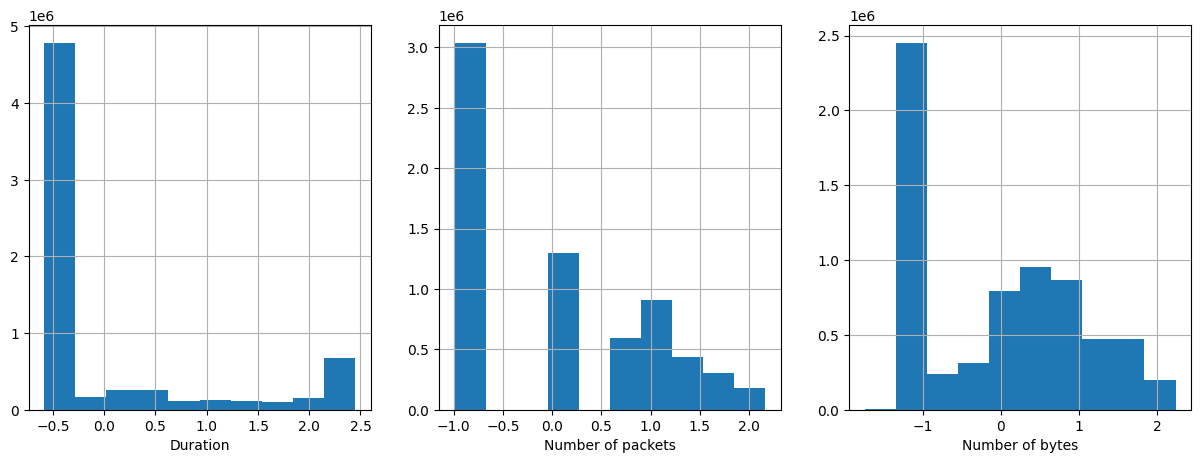

In [15]:
#Plotting the scaled distribution
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,5))
df_train['Duration'].hist(ax=ax1)
ax1.set_xlabel("Duration")
df_train['Packets'].hist(ax=ax2)
ax2.set_xlabel("Number of packets")
df_train['Bytes'].hist(ax=ax3)
ax3.set_xlabel("Number of bytes")
plt.show()

Converting to a graph dataset

In [16]:
BATCH_SIZE = 16
features_host = [f'ipsrc_{i}' for i in range(1, 17)] + [f'ipdst_{i}' for i in range(1, 17)]
features_flow = ['daytime', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Duration', 'Packets', 'Bytes', 'ACK', 'PSH', 'RST', 'SYN', 'FIN', 'ICMP ', 'IGMP ', 'TCP  ', 'UDP  ']

In [17]:
def get_connections(ip_map, src_ip, dst_ip):
    src1 = [ip_map[ip] for ip in src_ip]
    src2 = [ip_map[ip] for ip in dst_ip]
    src = np.column_stack((src1, src2)).flatten()
    dst = list(range(len(src_ip)))
    dst = np.column_stack((dst, dst)).flatten()
    
    return torch.Tensor([src, dst]).int(), torch.Tensor([dst, src]).int()

In [18]:
def create_dataloader(df, subgraph_size=1024):
    data = []
    n_subgraphs = len(df) // subgraph_size
    for i in range(1, n_subgraphs+1):
        subgraph = df[(i-1)*subgraph_size:i*subgraph_size]
        src_ip = subgraph['Src IP Addr'].to_numpy()
        dst_ip = subgraph['Dst IP Addr'].to_numpy()
        
        ip_map = {ip:index for index, ip in enumerate(np.unique(np.append(src_ip, dst_ip)))}
        host_to_flow, flow_to_host = get_connections(ip_map, src_ip, dst_ip)

        batch = HeteroData()
        #print(type(subgraph[features_host].to_numpy()))
        #print(torch.Tensor(subgraph[features_host].to_numpy()))
        batch['host'].x = torch.tensor(subgraph[features_host].to_numpy()).float()
        #print((subgraph[features_flow].to_numpy()).dtype)
        features_flow_object=np.vstack(subgraph[features_flow].to_numpy()).astype(float)
        #print(features_flow_object.dtype)
        #batch['flow'].x = torch.tensor(subgraph[features_flow].to_numpy()).float()
        batch['flow'].x = torch.tensor(features_flow_object).float()
        batch['flow'].y = torch.tensor(subgraph[labels].to_numpy()).float()
        batch['host','flow'].edge_index = host_to_flow
        batch['flow','host'].edge_index = flow_to_host
        data.append(batch)

    return DataLoader(data, batch_size=BATCH_SIZE)

In [19]:
train_loader = create_dataloader(df_train)
val_loader = create_dataloader(df_val)
test_loader = create_dataloader(df_test)

/var/folders/bb/1pgmng2s0xl2b26dxfj33phm0000gn/T/ipykernel_84329/2910756583.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  return torch.Tensor([src, dst]).int(), torch.Tensor([dst, src]).int()


In [24]:
from torch_geometric.nn import Linear, HeteroConv, SAGEConv, GATConv

class HeteroGNN(torch.nn.Module):
    def __init__(self, dim_h, dim_out, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                #('host', 'to', 'flow'): SAGEConv((-1,-1), dim_h, add_self_loops=False),
                ('host', 'to', 'flow'): SAGEConv((-1,-1), dim_h),
                #('flow', 'to', 'host'): SAGEConv((-1,-1), dim_h, add_self_loops=False),
                ('flow', 'to', 'host'): SAGEConv((-1,-1), dim_h),
            }, aggr='sum')
            self.convs.append(conv)

        self.lin = Linear(dim_h, dim_out)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['flow'])

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HeteroGNN(dim_h=64, dim_out=5, num_layers=3).to(device)
optimizer = Adam(model.parameters(), lr=0.001)

@torch.no_grad()
def test(loader):
    model.eval()
    y_pred = []
    y_true = []
    n_subgraphs = 0
    total_loss = 0

    for batch in loader:
        batch.to(device)
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.cross_entropy(out, batch['flow'].y.float())
        y_pred.append(out.argmax(dim=1))
        y_true.append(batch['flow'].y.argmax(dim=1))
        n_subgraphs += BATCH_SIZE
        total_loss += float(loss) * BATCH_SIZE
        
    y_pred = torch.cat(y_pred).cpu()
    y_true = torch.cat(y_true).cpu()
    f1score = f1_score(y_true, y_pred, average='macro')

    return total_loss/n_subgraphs, f1score, y_pred, y_true


model.train()
for epoch in range(101):
    n_subgraphs = 0
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        batch.to(device)
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.cross_entropy(out, batch['flow'].y.float())
        loss.backward()
        optimizer.step()

        n_subgraphs += BATCH_SIZE
        total_loss += float(loss) * BATCH_SIZE

    if epoch % 10 == 0:
        val_loss, f1score, _, _ = test(val_loader)
        print(f'Epoch {epoch} | Loss: {total_loss/n_subgraphs:.4f} | Val loss: {val_loss:.4f} | Val F1-score: {f1score:.4f}')

Epoch 0 | Loss: 0.0865 | Val loss: 0.0069 | Val F1-score: 0.5939
Epoch 10 | Loss: 0.0020 | Val loss: 0.0021 | Val F1-score: 0.8897
Epoch 20 | Loss: 0.0015 | Val loss: 0.0016 | Val F1-score: 0.9106
Epoch 30 | Loss: 0.0012 | Val loss: 0.0013 | Val F1-score: 0.9239
Epoch 40 | Loss: 0.0010 | Val loss: 0.0011 | Val F1-score: 0.9385
Epoch 50 | Loss: 0.0009 | Val loss: 0.0011 | Val F1-score: 0.9374
Epoch 60 | Loss: 0.0008 | Val loss: 0.0010 | Val F1-score: 0.9417
Epoch 70 | Loss: 0.0006 | Val loss: 0.0009 | Val F1-score: 0.9606
Epoch 80 | Loss: 0.0005 | Val loss: 0.0010 | Val F1-score: 0.9684
Epoch 90 | Loss: 0.0004 | Val loss: 0.0009 | Val F1-score: 0.9752
Epoch 100 | Loss: 0.0004 | Val loss: 0.0011 | Val F1-score: 0.9674


In [26]:
_, _, y_pred, y_true = test(test_loader)

print(classification_report(y_true, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      benign     0.9999    0.9998    0.9998    700791
  bruteForce     0.9810    0.9568    0.9688       162
         dos     1.0000    1.0000    1.0000    125164
    pingScan     0.9728    0.8512    0.9079       336
    portScan     0.9898    0.9949    0.9923     18347

    accuracy                         0.9997    844800
   macro avg     0.9887    0.9605    0.9738    844800
weighted avg     0.9997    0.9997    0.9997    844800



([<matplotlib.patches.Wedge at 0x4551232f0>,
 [Text(0.07095933240689042, 1.0977088744946761, 'benign'),
  Text(-0.6989756061456835, -0.8493721810921726, 'bruteForce'),
  Text(0.8341363175891653, -0.717088978913208, 'dos'),
  Text(1.094847200699616, -0.1063466366191943, 'pingScan'),
  Text(1.0999363350950757, -0.011834641423104182, 'portScan')],
 [Text(0.03870509040375841, 0.5987502951789142, '48%'),
  Text(-0.3812594215340092, -0.46329391695936684, '32%'),
  Text(0.45498344595772644, -0.39113944304356796, '17%'),
  Text(0.5971893821997905, -0.05800725633774234, '2%'),
  Text(0.599965273688223, -0.006455258958056826, '0%')])

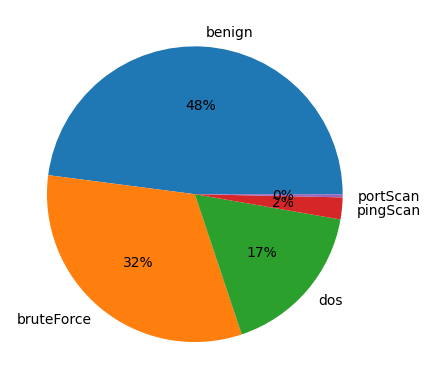

In [27]:
df_pred = pd.DataFrame([y_pred.numpy(), y_true.numpy()]).T
df_pred.columns = ['pred', 'true']
plt.pie(df_pred['true'][df_pred['pred'] != df_pred['true']].value_counts(), labels=labels, autopct='%.0f%%')

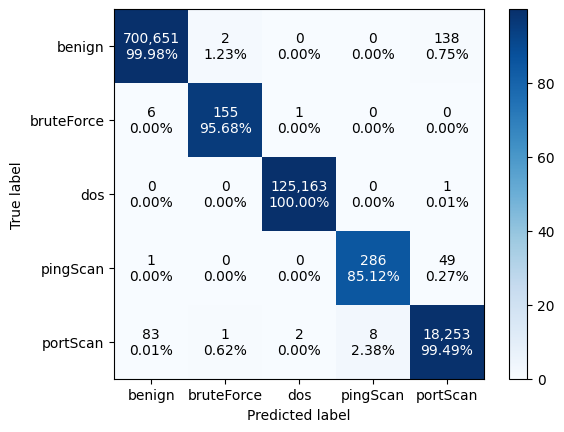

In [28]:
matrix = confusion_matrix(y_true, y_pred)
norm_matrix = matrix / matrix.sum(axis=1) * 100

plt.imshow(norm_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(range(len(labels)), labels)
plt.yticks(range(len(labels)), labels)
    
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
    text = f"{matrix[i,j]:,}\n{norm_matrix[i,j]:.2f}%"
    plt.text(j, i, text,
            horizontalalignment='center', verticalalignment='center',
            color='white' if matrix[i,j] >= matrix[i,:].mean() else 'black')
plt.show()